In [2]:
import pandas as pd
import os
from pathlib import Path
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
NEURAL_NETWORKS = ['DenseNet201', 'MobileNetV2', 'InceptionV3', "ResNet50"]
COLUMNS = ["val_accuracy", "val_precision", "val_specificity", "val_f1_score", "val_auc", "val_npv", "val_mcc"]
SUBSETS = ['Dataset01_100', 'Dataset01_95.0', 'Dataset01_90.0', 'Dataset01_85.0', 'Dataset01_80.0', 'Dataset01_75.0', 
           'Dataset01_70.0', 'Dataset01_65.0', 'Dataset01_60.0', 'Dataset01_55.0', 'Dataset01_50.0', 'Dataset01_45.0',
           'Dataset01_40.0', 'Dataset01_35.0', 'Dataset01_30.0', 'Dataset01_25.0', 'Dataset01_20.0', 'Dataset01_15.0', 
           'Dataset01_10.0', 'Dataset01_5.0']


In [4]:
path_project = Path().absolute().parent.parent.parent
results_path = path_project / "6_resultados"

output = results_path / "analitycs" / "by_test"

In [5]:
# for each network and subset, read all csv and save in dataframe

result = pd.DataFrame()

for network in NEURAL_NETWORKS:
    for subset in SUBSETS:
        # all csvs in this path
        csvs_path = results_path / subset / network / "metrics" / "csvs" / '_refined'
        csvs = os.listdir(csvs_path)
        for csv in csvs:
            if os.path.isfile(csvs_path / csv):
                ## add column model and subset
                df = pd.read_csv(csvs_path / csv)

                # join
                result = pd.concat([result, df], ignore_index=True)


In [6]:
#  Análise estatística (teste de hipótese)
#  hipotese: quero provar que a variação das ROI's influencia no desempenho e métricas dos modelos de redes neurais
#  hipotese nula (H0): as métricas de desempenho dos modelos de redes neurais são iguais entre cada subconjunto de dados (SUBSETS -> ROIS)
#  hipotese alternativa (H1): as métricas de desempenho dos modelos de redes neurais são diferentes entre cada subconjunto de dados (SUBSETS -> ROIS)
# alpha = 0.01, 1% de significância, de concluir que a hipótese nula é falsa quando ela é verdadeira.
# Valor-p (p-value)
## Se p-value < alpha: rejeita-se a hipótese nula (temos evidências suficientes para rejeitar a hipótese nula) (0) (green)
## Se p-value >= alpha: não rejeita-se a hipótese nula (não temos evidências suficientes para rejeitar a hipótese nula) (1) (red)
# Teste de hipótese: ranksums (teste de Mann-Whitney)



In [7]:
# modifiy code above to create a function that receives a dataframe and a roi and return a dataframe with p_values

def test_hyphotesis(main_pd, roi, alpha=0.01):
    """
    Função para testar a hipótese nula de que as métricas de desempenho dos modelos de redes neurais são iguais entre cada subconjunto de dados (SUBSETS -> ROIS).
    em relação a 100% de ROI.
    :param main_pd: DataFrame contendo todos os dados.
    :param roi: Tamanho da ROI (int).
    :return: DataFrame contendo os p-values de cada métrica para cada modelo de rede neural.
    """
    p_values = pd.DataFrame()
    for network in NEURAL_NETWORKS:
        network_data = main_pd[main_pd['network'] == network]
        roi_data = network_data[network_data['dataset'] == roi]
       
        # make for all atributtes
        for column in COLUMNS:
            p_value = ranksums(roi_data[column], network_data[network_data['dataset'] == 100][column], alternative='two-sided').pvalue
            if p_value < alpha:
                h = 0
            else:
                h = 1
            p_values = p_values._append({'network': network, 'roi': roi, 'column': column, 'p_value': p_value, 'h': h}, ignore_index=True)
        
    return p_values

result_p_values = pd.DataFrame()
for roi in result['dataset'].unique():
    result_p_values = pd.concat([result_p_values, test_hyphotesis(result, roi)], ignore_index=True)

result_p_values.to_csv(output / "p_values.csv", index=False)


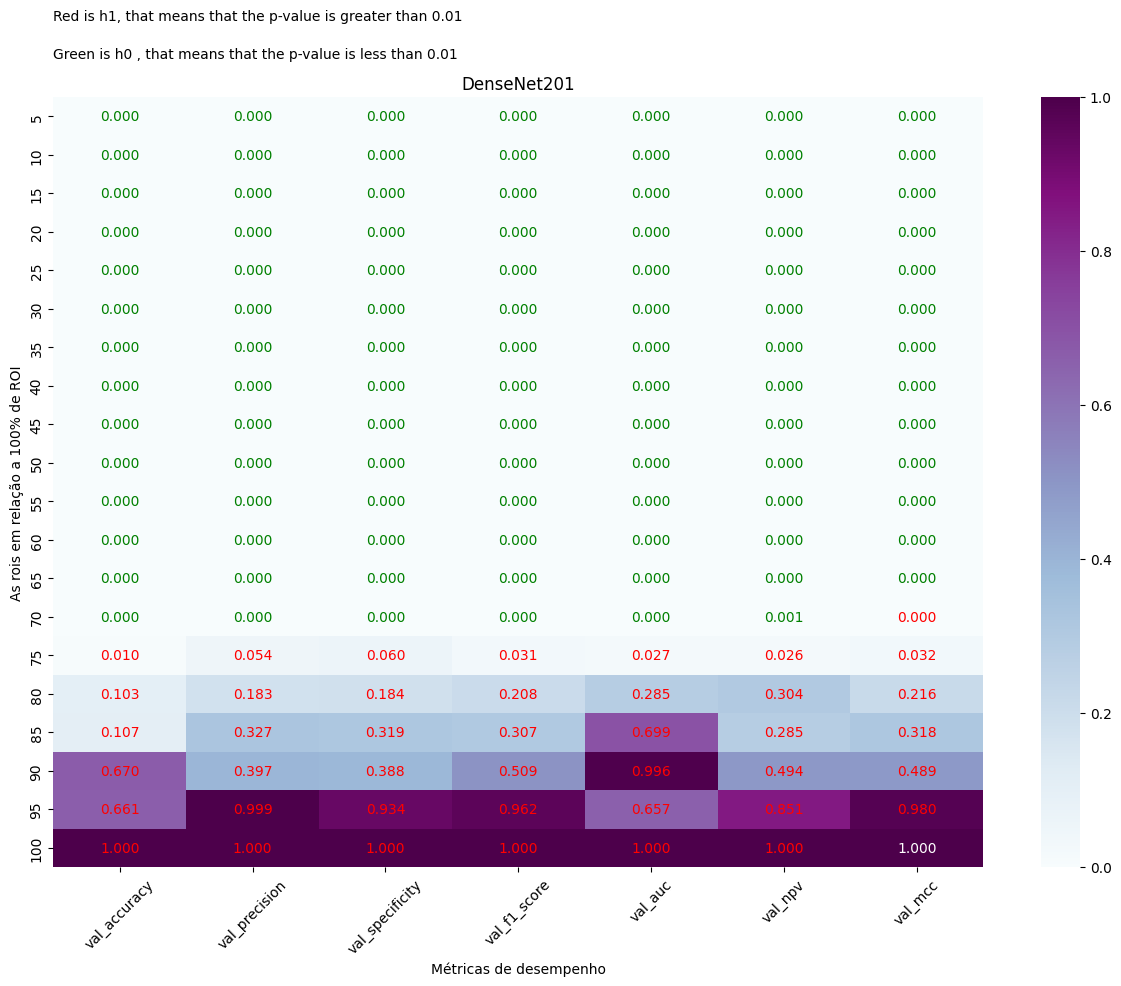

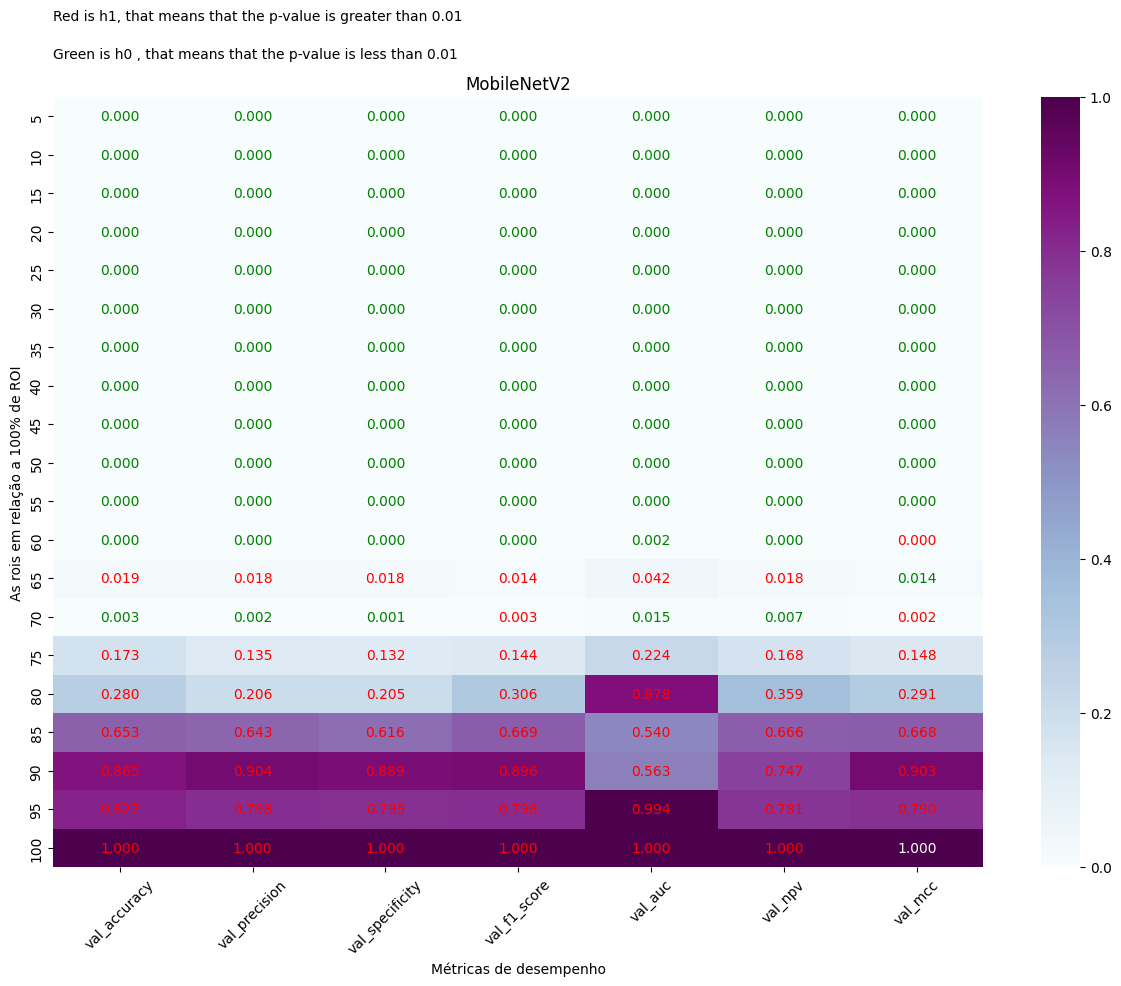

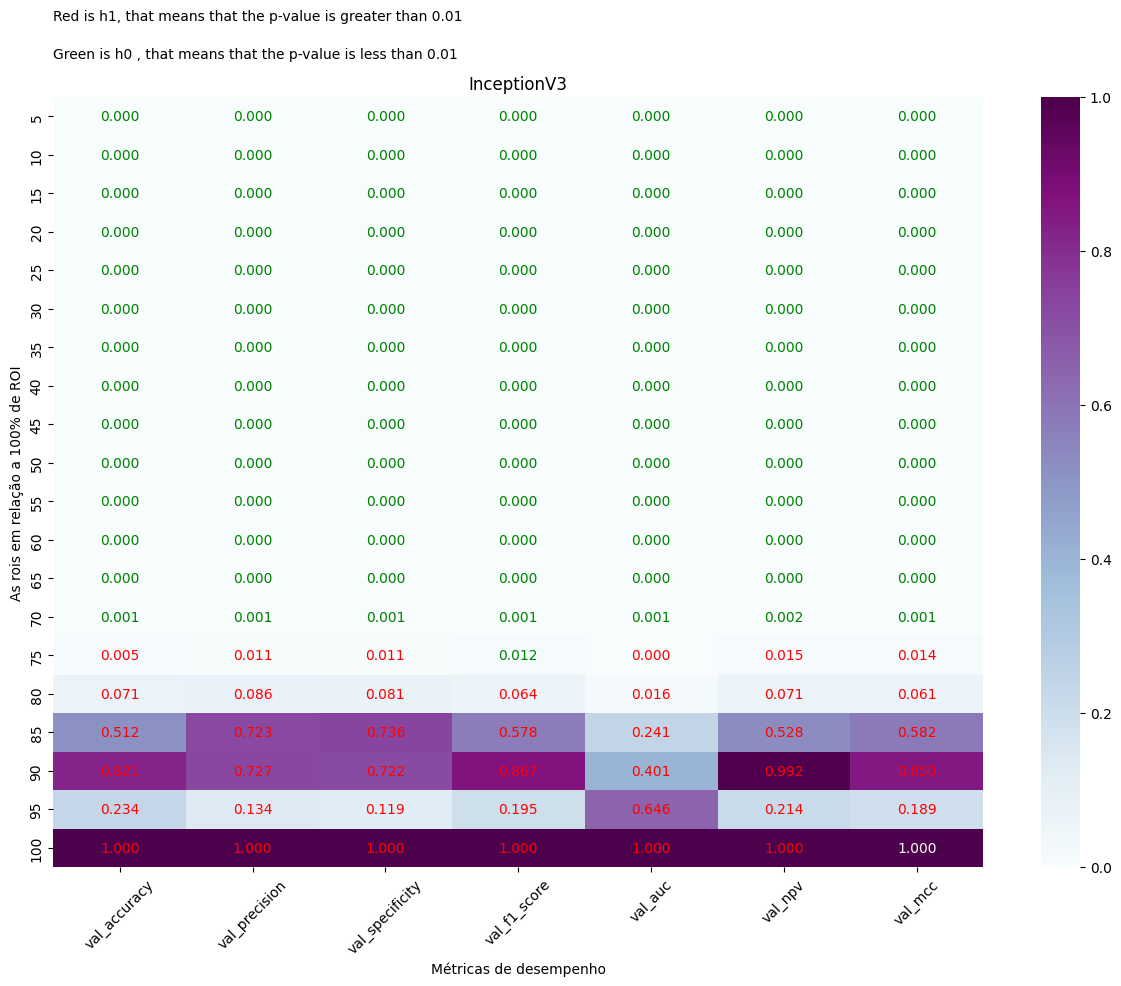

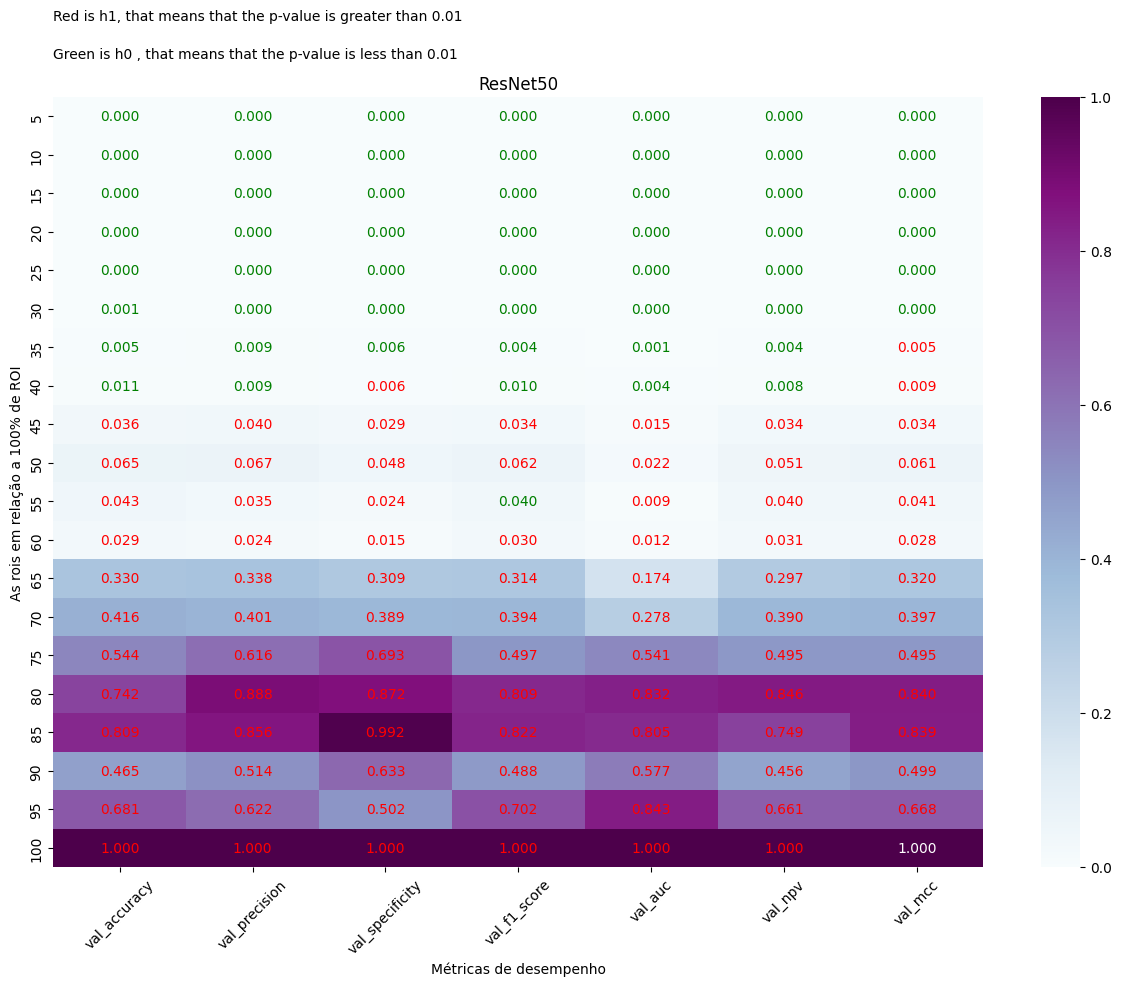

In [8]:

result_p_values = pd.read_csv(output / "p_values.csv")


"""
# plot table with all meansures by p_values for DenseNet201
densenet = result_p_values[result_p_values['network'] == 'DenseNet201']
densenet = densenet.pivot(index='roi', columns='column', values='p_value')
densenet = densenet[COLUMNS]
densenet = densenet.round(3)

plt.figure(figsize=(10, 5))
sns.heatmap(densenet, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("DenseNet201")
"""

# plot heatmap with all meansures by p_values for all networks, and fille with green h = 0 and red black = 1

for network in NEURAL_NETWORKS:
    network_data = result_p_values[result_p_values['network'] == network]
    network_data = network_data.pivot(index='roi', columns='column', values='p_value')
    network_data = network_data[COLUMNS]
    network_data = network_data.round(3)

    plt.figure(figsize=(15, 10))
    sns.heatmap(network_data, annot=True, cmap='BuPu', fmt=".3f")
    plt.title(network)
   

    # change colors if h = 0 or h = 1
    for i in range(len(network_data.index)):
        for j in range(len(network_data.columns)):
            if network_data.iloc[i, j] < 0.01:
                plt.gca().get_children()[i * len(network_data.columns) + j].set_color('green')
            else:
                plt.gca().get_children()[i * len(network_data.columns) + j].set_color('red')
    # labels
    # make label "As rois em relação a 100% de ROI"
    # make label "Métricas de desempenho"
    # make label "Green is h0 , that means that the p-value is less than 0.01" and "Red is h1, that means that the p-value is greater than 0.01"
    plt.xticks(rotation=45)
    plt.xlabel("Métricas de desempenho")
    plt.ylabel("As rois em relação a 100% de ROI")
    plt.text(0, -1, "Green is h0 , that means that the p-value is less than 0.01", fontsize=10)
    plt.text(0, -2, "Red is h1, that means that the p-value is greater than 0.01", fontsize=10)
    
    plt.savefig(output / f"{network}.png")
    plt.show(  )
